# scVI for monocyte

In [1]:
#Note: run in my cardec environment 
"""import scVI Package"""
#from scvi.dataset import GeneExpressionDataset,AnnDatasetFromAnnData
#from scvi.inference import UnsupervisedTrainer
#from scvi.models import VAE
import scvi
from scvi.model import SCVI

/home/xiaoxiang/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
"""Broadly useful python packages"""
import pandas as pd
import os,sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
from time import time
from copy import deepcopy

"""Machine learning and single cell packages"""
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import anndata
from anndata import AnnData
from keras.optimizers import Adam
from keras.models import Model
import tensorflow
import keras
import torch

Using TensorFlow backend.


In [3]:
print("The version of scvi is:",scvi.__version__)
print("The version of scanpy is:",sc.__version__)
print("The version of torch is:",torch.__version__)
print("The version of keras is:",keras.__version__)
print("The version of anndata is:",anndata.__version__)
print("The version of tensorflow is",tensorflow.__version__)

The version of scvi is: 0.7.0b0
The version of scanpy is: 1.6.0
The version of torch is: 1.5.1
The version of keras is: 2.3.1
The version of anndata is: 0.7.4
The version of tensorflow is 2.1.0


In [4]:
def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector, printkey = False):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    if printkey:
        print(pd.Series(vector_key))
    
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
            
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

In [5]:
#load data
adata = sc.read("../../raw_data/monocyte_desc_use.h5ad", cache=True)
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=30) # must filter that genes with all zeros
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata.obs['BatchID'] = adata.obs['dataset_batch'].copy()
adata.obs['BatchID_encode'] = convert_vector_to_encoding(adata.obs['BatchID'])
adata
#adata.write("dca_test.h5ad")

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 10878 × 11160
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID', 'BatchID_encode'
    var: 'genename', 'n_cells'

In [6]:
#create output dir
build_dir("scVI Results New/monocytes_ALL/models")

In [7]:
# read highly variabel genes CarDEC used
df0=pd.read_csv("CarDEC_hvg_used.tsv",sep="\t")
df0.head(10)

,genename,Variance Type
0,DPM1,LVG
1,SCYL3,LVG
2,C1orf112,LVG
3,FGR,LVG
4,FUCA2,LVG
5,GCLC,LVG
6,NFYA,LVG
7,NIPAL3,LVG
8,LAS1L,LVG
9,ENPP4,LVG


## 2. scVI Model using all genes
### 2. 1 denosied

In [8]:
torch.set_num_threads(4)
torch.manual_seed(1)

In [9]:
#scvi_rawdataset = AnnDatasetFromAnnData(ad = adata, batch_label='BatchID_encode')
#scvi_rawdataset.subsample_genes(new_n_genes=adata.shape[1])
#scvi_rawdataset
anndataset=adata.copy()
scvi.data.setup_anndata(anndataset, batch_key="BatchID")

INFO      Using batches from adata.obs["BatchID"]                                            
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 10878 cells, 11160 genes, 3      
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


In [10]:
#vae = SCVI(anndataset, n_layers = 2)
#help(vae.get_normalized_expression)

In [11]:
vae = SCVI(anndataset, n_layers = 2)
filename='scVI Results New/monocytes_ALL/bestmodelnew'
if not os.path.exists(filename):
    vae.train(n_epochs = 200)
    vae.save(dir_path = filename)
        
vae = vae.load(anndataset, dir_path = filename)

latent = vae.get_latent_representation()


INFO      Training for 200 epochs                                                            
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  2004 s. / 200 epochs                                               


In [20]:
normalized_values = vae.get_normalized_expression(
    library_size=1e4, 
    transform_batch = "MH001",
    n_samples=3, 
    return_mean=True
)

In [21]:
normalized_values.head(5)

index,DPM1,SCYL3,C1orf112,FGR,FUCA2,GCLC,NFYA,NIPAL3,LAS1L,ENPP4,...,CCDC7.1,CALML5,KCNJ3,PRR7-AS1,AC131056.5,HBA1,CXCL14,KRT81,LINC01481.1,RP1-17K7.2
index,,,,,,,,,,,,,,,,,,,,,
CTCTACGCACAGACAG-1-MH001,0.449038,0.049919,0.068501,3.427355,0.194469,0.024298,0.100195,0.062378,0.099511,0.046333,...,0.002727,3.136830,0.006170,0.006951,0.016565,3.880151,0.059838,0.126088,0.020272,0.013958
ACGCCAGAGATGTAAC-1-MH001,0.428002,0.032707,0.026023,2.632231,0.266580,0.108576,0.055448,0.030259,0.077902,0.029835,...,0.009575,0.035840,0.006696,0.003285,0.005695,0.004781,0.007636,0.009013,0.012502,0.008137
AGAGTGGGTATAGTAG-1-MH001,0.279389,0.028175,0.020082,2.551565,0.219767,0.133572,0.061606,0.036153,0.146405,0.028145,...,0.003574,0.022465,0.010984,0.002678,0.009419,0.018011,0.013133,0.011729,0.019902,0.012780
GTATCTTCATCGGAAG-1-MH001,0.271302,0.082481,0.018128,2.214617,0.239276,0.119101,0.039582,0.096212,0.063223,0.011133,...,0.004012,0.076835,0.026658,0.002692,0.011869,0.089242,0.012804,0.038876,0.024734,0.005242
AACCGCGGTGCGGTAA-1-MH001,0.366570,0.041413,0.072324,3.828487,0.393521,0.168717,0.068050,0.068253,0.246726,0.088350,...,0.006558,0.017100,0.039722,0.008225,0.030435,0.020842,0.034335,0.019002,0.022793,0.104337


In [22]:
formatting = AnnData(normalized_values,obs=adata.obs.copy())
formatting.X.sum(1)

array([10000.   , 10000.002,  9999.999, ..., 10000.   ,  9999.999,
       10000.001], dtype=float32)

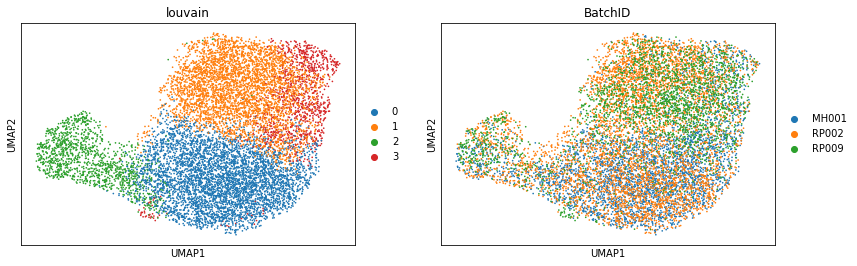

In [23]:
#scvi_adata = anndata.AnnData(data - 1)
formatting = AnnData(normalized_values,obs=adata.obs.copy())
#sc.pp.normalize_total(formatting,target_sum=1e4)#target_sum=1e4
sc.pp.log1p(formatting)
#sc.pp.highly_variable_genes(formatting, inplace = True, min_mean = 0.0125, max_mean = 3, min_disp = 0.5, 
#                                          n_bins = 20, n_top_genes = 1000, batch_key = "BatchID",subset=True)
sc.pp.scale(formatting)
sc.tl.pca(formatting, svd_solver='arpack')
sc.pp.neighbors(formatting,n_neighbors = 15)#n_neighbors = 15
sc.tl.umap(formatting)
res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)
sc.pl.umap(formatting, color = ["louvain", "BatchID"], show=True)

In [25]:
sum(anndataset.obs.cellname==normalized_values.index)

10878

In [27]:
sum(anndataset.var.genename==normalized_values.columns)

11160

In [28]:
scvi_adata=sc.AnnData(normalized_values,obs=anndataset.obs.copy(),var=anndataset.var.copy())
scvi_adata.obsm['X_umap_denoised']=formatting.obsm['X_umap'].copy()
scvi_adata.obsm['X_pca_denoised']=formatting.obsm['X_pca'].copy()
scvi_adata.obs['louvain_denoised']=formatting.obs['louvain'].copy()

###  2. 2 latent

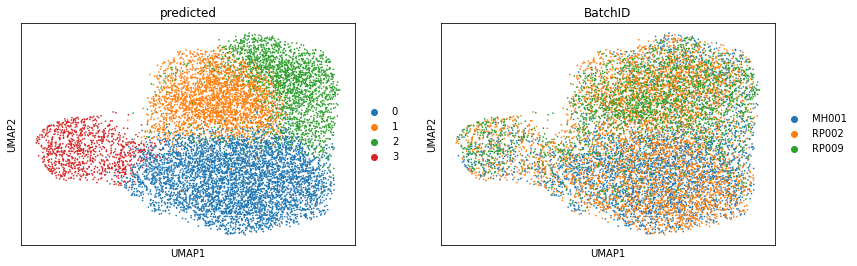

In [29]:
formatting = AnnData(deepcopy(latent),obs=adata.obs.copy())
sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')
res = find_resolution(formatting, 4) #cannot detect more than 12 cell types reliably
sc.tl.louvain(formatting, resolution = res)
sc.tl.umap(formatting)
formatting.obs['predicted'] = formatting.obs['louvain']
#type_strings = list(HVG_denoised.obs['celltype'])
sc.pl.umap(formatting, color = ["predicted", "BatchID"], show=True)

In [30]:
scvi_adata.obsm['X_umap_latent']=formatting.obsm['X_umap'].copy()
scvi_adata.obsm['X_latent']=deepcopy(latent)
scvi_adata.obs['louvain_latent']=formatting.obs['louvain'].copy()

In [32]:
scvi_adata.write("scVI Results New/monocytes_ALL/adata_all.h5ad")